In [1]:
# In[1]: Import Required Libraries
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
import torch.nn as nn
import torch.optim as optim
# In[2]: Load and Split Dataset
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# In[2]: Load Dataset
import pandas as pd
from sklearn.model_selection import train_test_split

# Paths /Users/zafercalisir/Desktop/GradProj/CheXnet-App/ChestX-ray14/Combined_Train_and_Test_Data.csv
data_csv = "ChestX-ray14/Filtered_Cases_with_One_or_No_Finding.csv"
image_directory = "/Users/zafercalisir/Desktop/GradProj/cnn-in-nih14/dataset/images-224/images-224"

# Load the dataset
data = pd.read_csv(data_csv)

# Filter out labels with fewer than 2 samples
filtered_data = data.groupby('Finding Labels').filter(lambda x: len(x) > 5)

# Verify filtered class distribution
print("Filtered Class Distribution:")
print(filtered_data['Finding Labels'].value_counts())

# Split the filtered dataset into train, validation, and test sets
# Step 1: Train/Test Split
train_data, temp_data = train_test_split(
    filtered_data, 
    test_size=0.3, 
    stratify=filtered_data['Finding Labels'], 
    random_state=42
)

# Step 2: Validation/Test Split
val_data, test_data = train_test_split(
    temp_data, 
    test_size=0.5, 
    stratify=temp_data['Finding Labels'], 
    random_state=42
)

# Display dataset sizes
print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}, Test size: {len(test_data)}")


Filtered Class Distribution:
Finding Labels
No Finding      5128
Infiltration    3004
Nodule          2886
Pneumothorax    2838
Atelectasis     2397
Effusion        2320
Name: count, dtype: int64
Train size: 13001, Validation size: 2786, Test size: 2786


In [3]:
class ChestXRayDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

        # Validate the dataset
        valid_samples = []
        for idx in range(len(self.dataframe)):
            row = self.dataframe.iloc[idx]
            image_path = os.path.join(self.image_dir, row['Image Index'])
            if os.path.exists(image_path):
                valid_samples.append(row)
            else:
                print(f"Missing image: {image_path}")
        self.dataframe = pd.DataFrame(valid_samples)

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = os.path.join(self.image_dir, row['Image Index'])
        try:
            image = Image.open(image_path).convert("L")  # Convert to grayscale
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return self.__getitem__((idx + 1) % len(self.dataframe))  # Skip problematic image

        label = row['Finding Labels']
        findings = ["Infiltration", "Atelectasis", "Effusion", "Nodule", "Pneumothorax", "No Finding"]
        label_vector = [1 if finding in label else 0 for finding in findings]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label_vector, dtype=torch.float)


In [41]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch

class ChestXRayDataset(Dataset):
    def __init__(self, dataframe, image_directory, transform=None):
        self.dataframe = dataframe
        self.image_directory = image_directory
        self.transform = transform
        # Define the label mapping
        self.label_mapping = {
            'No Finding': [1, 0, 0, 0, 0, 0],
            'Pneumonia': [0, 1, 0, 0, 0, 0],
            'Infiltration': [0, 0, 1, 0, 0, 0],
            'Tuberculosis': [0, 0, 0, 1, 0, 0],
            'Cardiomegaly': [0, 0, 0, 0, 1, 0],
            'Pneumothorax': [0, 0, 0, 0, 0, 1],
        }

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = f"{self.image_directory}/{row['Image Index']}"  # Use correct column name
        image = Image.open(image_path).convert('L')  # Convert to grayscale

        # Map categorical label to numeric encoding
        label_str = row['Finding Labels']  # Assuming label is a string or comma-separated list
        if ',' in label_str:  # Handle multi-label cases
            label = [0] * len(self.label_mapping)  # Initialize a zero vector
            for label_part in label_str.split(','):
                label_part = label_part.strip()
                if label_part in self.label_mapping:
                    label = [x + y for x, y in zip(label, self.label_mapping[label_part])]
        else:
            label = self.label_mapping.get(label_str.strip(), [0, 0, 0, 0, 0, 0])

        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)



# Data Augmentation and Normalization
train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Dataset and DataLoader
train_dataset = ChestXRayDataset(train_data, image_directory, transform=train_transform)
val_dataset = ChestXRayDataset(val_data, image_directory, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [39]:
from torchvision import models
import torch.nn as nn

# Load Pretrained ResNet50
model = models.resnet50(pretrained=True)

# Modify the First Layer for Grayscale Input
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the Fully Connected Layer for Multi-Label Classification
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 6)  # Output for 6 classes
)

# Initialize Weights for New Layers
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

model.fc.apply(init_weights)

# Loss, Optimizer, and Scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Fine-tuning the Last Few Layers
for param in model.layer4.parameters():
    param.requires_grad = True

# Freeze Earlier Layers
for param in list(model.parameters())[:-len(list(model.layer4.parameters()))]:
    param.requires_grad = False

# Move Model to Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/Users/zafercalisir/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/zafercalisir/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
print(train_data.shape)  # Should print (num_samples, 6)


(13001, 14)


In [30]:
# Convert class counts to tensor
class_distribution = torch.tensor([class_counts[finding] for finding in findings], dtype=torch.float)
print(f"Class distribution: {class_distribution}")


Class distribution: tensor([2103., 1678., 1624., 2020., 1987., 3589.])


In [42]:
from tqdm import tqdm
import numpy as np

# Define EarlyStopping Class
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='best_model.pth.tar'):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf

    def __call__(self, val_loss, model, optimizer, epoch):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, epoch)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, epoch)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, optimizer, epoch):
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, self.path)
        self.val_loss_min = val_loss

# Initialize EarlyStopping
early_stopping = EarlyStopping(patience=5, verbose=True, path='best_model.pth.tar')

# Training Loop
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=True)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        progress_bar.set_postfix({"Training Loss": running_loss / len(progress_bar)})

    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {running_loss / len(train_loader):.4f}")

    # Validation Phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

    val_loss /= len(val_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")

    # Early Stopping
    early_stopping(val_loss, model, optimizer, epoch)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# Load the Best Model
checkpoint = torch.load('best_model.pth.tar')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']} with validation loss: {checkpoint['val_loss']:.4f}")


Epoch 1/50:  16%|█▋        | 67/407 [05:02<25:33,  4.51s/it, Training Loss=0.0589]


KeyboardInterrupt: 

In [11]:
checkpoint = torch.load('best_model.pth.tar')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

/var/folders/y2/m1n7lqf10t99jk_mtznp43yh0000gn/T/ipykernel_14670/2210013568.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth.tar')

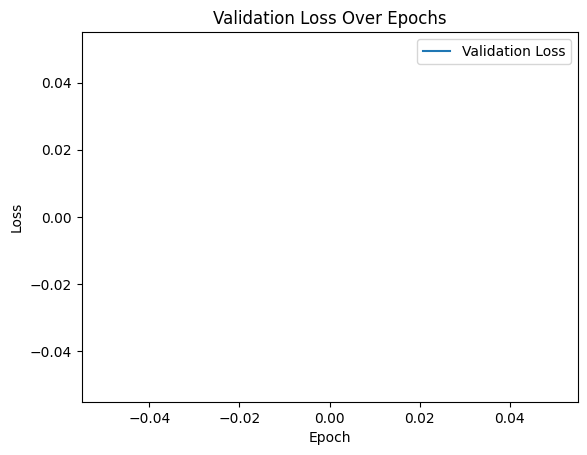

In [12]:
import matplotlib.pyplot as plt

plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()
plt.show()


In [ ]:
from tqdm import tqdm
import numpy as np
import torch

model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Validating", leave=True):  # Wrap the DataLoader with tqdm
        images = images.to(device)
        outputs = model(images)  # Raw logits
        probabilities = torch.sigmoid(outputs).cpu().numpy()  # Convert logits to probabilities
        y_pred.extend(probabilities)
        y_true.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)


Validating: 100%|██████████| 88/88 [05:57<00:00,  4.06s/it]


In [16]:
from sklearn.metrics import roc_auc_score

class_names = ["Infiltration", "Atelectasis", "Effusion", "Nodule", "Pneumothorax", "No Finding"]

# Assuming y_true (ground truth) and y_pred (predictions) are numpy arrays
# Shape: [num_samples, num_classes]
aurocs = {}
for i, class_name in enumerate(class_names):  # Replace class_names with your actual class names
    try:
        auroc = roc_auc_score(y_true[:, i], y_pred[:, i])
        aurocs[class_name] = auroc
    except ValueError:
        # Handle case where a class has only one label value (all 0s or 1s)
        aurocs[class_name] = None
        print(f"AUROC for {class_name} could not be calculated due to single-class labels.")

# Print AUROC for each class
for class_name, auroc in aurocs.items():
    if auroc is not None:
        print(f"AUROC for {class_name}: {auroc:.4f}")
    else:
        print(f"AUROC for {class_name}: Not Applicable")


AUROC for Infiltration: 0.6855
AUROC for Atelectasis: 0.7382
AUROC for Effusion: 0.7952
AUROC for Nodule: 0.6755
AUROC for Pneumothorax: 0.7887
AUROC for No Finding: 0.7075


In [17]:
valid_aurocs = [auroc for auroc in aurocs.values() if auroc is not None]
average_auroc = sum(valid_aurocs) / len(valid_aurocs) if valid_aurocs else 0
print(f"Average AUROC: {average_auroc:.4f}")


Average AUROC: 0.7318


In [ ]:
# In[9]: Save Model
torch.save(model.state_dict(), "chest_xray_model.pth.tar")
print("Model saved as 'chest_xray_model.pth.tar'")